In [4]:
!python -m spacy download es_core_news_lg -q
import spacy
nlp=spacy.load("es_core_news_lg")
ruler = nlp.add_pipe("entity_ruler")

[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [5]:
import nltk
import pandas as pd
import numpy as np
from IPython.display import display
!pip install --upgrade matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
import re
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import joblib
from joblib import load 
from joblib import dump
from sklearn.utils import shuffle
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Samuel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Samuel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Samuel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.utils import shuffle

In [10]:
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^\w\s]', '', texto)  
    texto = re.sub(r'\d+', '', texto)     
    palabras =word_tokenize(texto)
    doc = nlp(' '.join(palabras))
    palabras = [token.lemma_ for token in doc]
    return ' '.join(palabras)


In [12]:
df=pd.read_csv('Sentimento_completo.csv')
df_produccion=df[df['Label']=='PRODUCCION']
df_produccion=df_produccion.reset_index(drop=True)
df_produccion

,Unnamed: 0,Label,Entity,Review,continent
0,2,PRODUCCION,escenas,Las escenas de batalla son impresionantes,EEUU
1,4,PRODUCCION,visual,sigue siendo un gran espectáculo visual y un d...,EEUU
2,10,PRODUCCION,producción,Si bien la producción es impecable,EUROPE
3,17,PRODUCCION,escenas,"""Gladiator 2"" logra mantener el espíritu de la...",EUROPE
4,21,PRODUCCION,escenas,Aunque la cinematografía es espectacular y las...,EEUU
5,30,PRODUCCION,visual,logra construir su propia identidad y ofrece u...,EEUU
6,33,PRODUCCION,escenas,Aunque tiene buenas escenas de acción y una ba...,EEUU
7,43,PRODUCCION,producción,"""Gladiator 2"" nos devuelve a la Roma imperial ...",EUROPE
8,55,PRODUCCION,producción,Las secuencias de acción son emocionantes y el...,EEUU
9,59,PRODUCCION,visual,es un deleite visual y una experiencia épica.,EEUU


In [19]:
entidades_semanticas = {
    "GENERAL": {"tipo_semantico":"Película","entidades":["Gladiator 2","secuela","continuacion","película"]},
    "DIRECTOR": {"tipo_semantico": "Persona", "entidades": ["Ridley Scott"]},
    "ACTOR": {"tipo_semantico": "Persona", "entidades": ["Paul Mescal", "Denzel Washington", "Pedro Pascal"]},
    "PRODUCCION": {"tipo_semantico": "Objeto Fílmico", "entidades": ["Ridley Scott","producción","visual", "escenas", "efectos especiales","coreografias","música","dirección","ambientación","dirección","secuencias"]},
    "GUION": {"tipo_semantico": "Objeto escrito", "entidades": ["trama","historia","narrativa","guion","desarrollo","profundidad","personajes"]}
}

In [21]:
patterns = []
for categoria, datos in entidades_semanticas.items():
    for entidad in datos["entidades"]:
        patterns.append({"label": categoria, "pattern": entidad})
ruler.add_patterns(patterns)

In [23]:
model_X= load("modelo_SVC.pkl")
vectorizer=load("vectorizador_tfidf.pkl")


In [25]:

mapeo_sentimientos = {-1: 'NEG', 0: 'NEU',1: 'POS'}
#predictions.clear
predictions=[]
for index,row in df_produccion.iterrows():
    comentarios=row['Review']
    continente=row['continent']
    label=row['Label']
    entity=row['Entity']
    text=limpiar_texto(comentarios)
    text_vec=vectorizer.transform([text])
    pred=model_X.predict(text_vec) 
    sent_map = mapeo_sentimientos[pred[0]]
    text_pred=label,entity,comentarios,continente,sent_map
    predictions.append(text_pred)
pd.set_option('display.max_colwidth', None)
   
Df_Produccion=pd.DataFrame(predictions,columns=['Label','Entity','Review','Continent','Sentiment'])
Df_Produccion = Df_Produccion.drop_duplicates(subset=['Review'], keep='first')
pd.set_option('display.max_colwidth', None)
Df_Produccion.to_csv('Production.csv')
Df_Produccion


,Label,Entity,Review,Continent,Sentiment
0,PRODUCCION,escenas,Las escenas de batalla son impresionantes,EEUU,NEU
1,PRODUCCION,visual,sigue siendo un gran espectáculo visual y un digno sucesor del clásico.,EEUU,POS
2,PRODUCCION,producción,Si bien la producción es impecable,EUROPE,POS
3,PRODUCCION,escenas,"""Gladiator 2"" logra mantener el espíritu de la primera película con escenas de batalla bien coreografiadas y una banda sonora poderosa.",EUROPE,POS
4,PRODUCCION,escenas,Aunque la cinematografía es espectacular y las escenas de acción están bien logradas,EEUU,NEU
5,PRODUCCION,visual,logra construir su propia identidad y ofrece un espectáculo visual impresionante.,EEUU,POS
6,PRODUCCION,escenas,Aunque tiene buenas escenas de acción y una banda sonora impresionante,EEUU,NEU
7,PRODUCCION,producción,"""Gladiator 2"" nos devuelve a la Roma imperial con una producción impecable y un elenco estelar.",EUROPE,POS
8,PRODUCCION,producción,Las secuencias de acción son emocionantes y el diseño de producción es exquisito.,EEUU,POS
9,PRODUCCION,visual,es un deleite visual y una experiencia épica.,EEUU,POS


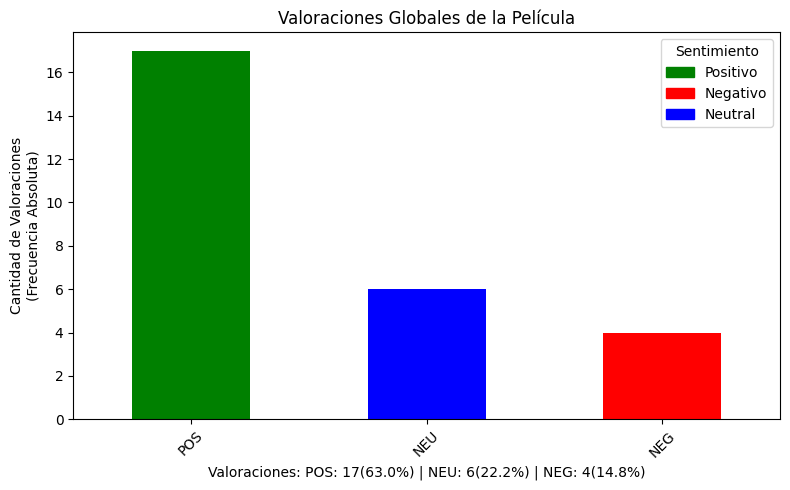

In [27]:
Produccion_sentiment= Df_Produccion['Sentiment'].value_counts()
frecuency_rel = Produccion_sentiment / Produccion_sentiment.sum() * 100 
category=['POS', 'NEU', 'NEG']
Produccion_sentiment2 = Produccion_sentiment.reindex(category, fill_value=0)
colors= {'POS': 'green', 'NEG': 'red', 'NEU': 'blue'}
ax=Produccion_sentiment2.plot(kind='bar',figsize=(8, 5),color=[colors[label] for label in Produccion_sentiment2.index])
plt.title('Valoraciones Globales de la Película')
sentiment_text = " | ".join([f"{key}: {value}({frecuency_rel[key]:.1f}%)" for key, value in Produccion_sentiment2.items()])
plt.xlabel(f"Valoraciones: {sentiment_text}")
plt.ylabel('Cantidad de Valoraciones\n(Frecuencia Absoluta)' )
plt.xticks(rotation=45)
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in colors.keys()]
labels = ['Positivo', 'Negativo', 'Neutral'] 
plt.legend(handles, labels, title='Sentimiento', loc='upper right')

plt.tight_layout()

plt.show()

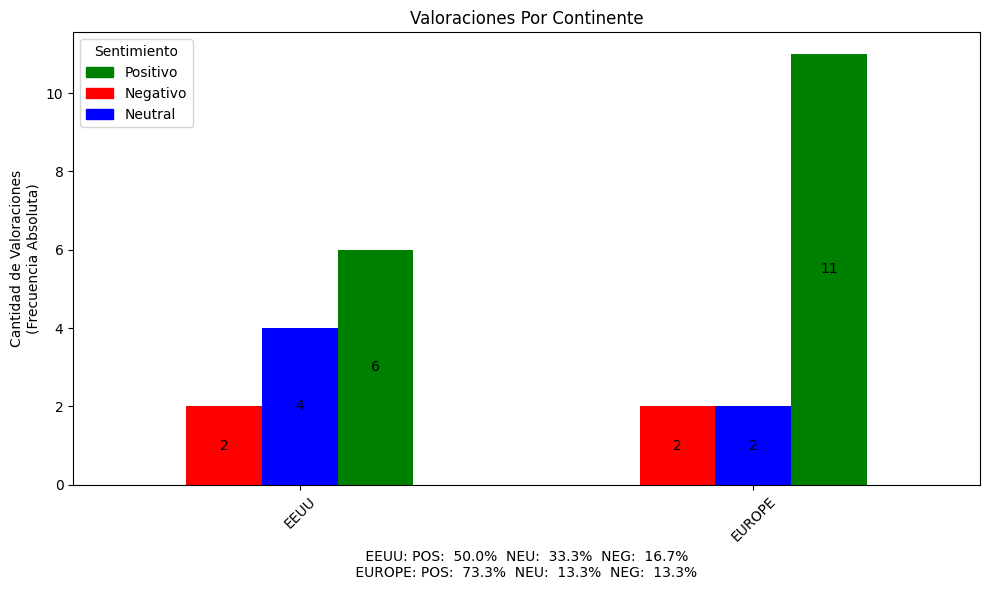

In [29]:
Produccion_cont_sentiment =  Df_Produccion.groupby(['Continent', 'Sentiment']).size().unstack(fill_value=0)

# Crear gráfico de barras apiladas
ax=Produccion_cont_sentiment.plot(kind='bar', stacked=False, figsize=(10, 6), color={'POS': 'green', 'NEG': 'red','NEU':'blue'})
frecuencia_rel= Produccion_cont_sentiment.div(Produccion_cont_sentiment.sum(axis=1), axis=0) * 100
frecuencia_rel= frecuencia_rel.reindex(columns=category, fill_value=0)
frecuencia_text ="\n ".join([
    f"{continent}: "+" ".join([f"{col}:  {frecuencia_rel.loc[continent, col]:.1f}% " for col in frecuencia_rel.columns])
    for continent in frecuencia_rel.index
])
plt.title('Valoraciones Por Continente')
plt.xlabel(f" {frecuencia_text}")
plt.ylabel('Cantidad de Valoraciones\n(Frecuencia Absoluta)')
plt.xticks(rotation=45)
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in colors.keys()]
labels = ['Positivo', 'Negativo', 'Neutral']  # Describe los colores en la leyenda
plt.legend(handles, labels, title='Sentimiento', loc='upper left')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='center') 
plt.tight_layout()
plt.show()